# 逾期还款的客户特征分析

## 目标：

1. 什么样的**客户**容易借贷违约
2. 什么样的**因素**与违约有关
3. 如何精准营销


In [120]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!pwd

/content


In [3]:
# CPU!!! --gdrive
#google colab - change path to google drive

import os 
os.chdir('gdrive/My Drive/Colab Notebooks/vmor_practicum/bank_customer')
!pwd

/content/gdrive/My Drive/Colab Notebooks/vmor_practicum/bank_customer


In [4]:
!ls

bank_customer.ipynb  data


In [0]:
# import libraries
import numpy as np
import pandas as pd
#import datetime as dt

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns


# magic word for producing visualizations in notebook
%matplotlib inline

In [0]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [0]:
my_color = ['#42bff4', '#f9ace9']

# Step 1： Preprocessing data

## Import Data



In [124]:
df = pd.read_csv('data/data.csv')
df.head(1)

,Contract_Number,Consumer_ID,Product,Contract_Status,Application Date,Entry Date,StartHalf,First Installment Date,Purchase Amt,Deposit Amt,Financed Amt,Deposit_Percent,Total Term,Term_Run,Term_Remaining,Payment Type,Total No Of Payments,Freq,Instalment Amt,Total Payments Received,Total Balance Outstanding,Amt Paid To Merchant_nettofmerchfeesandGST,Gtee Rate,Gtee Charges,Est Fees,Proc Fees,Other Fees,Total Merchant Charges,Total Consumer Charges,Total Charges,Effective Billing Rate,Expected Contract End Date,No Of Days In Default,Arrears Amount,No Of Days In Arrears,DefaultAmount,DefaultDate,MonthsToDefault,Recent Default_Default Date,Recent Default_Default Amt,Recent Default_Recov Amt,Recent Default_Cure Date,Consumer Post Code,Consumer Year Of Birth,Merchant Number,Merchant Name,Industry Name,Homowner Ind,Homowner Consumer
0,61201613,L61201613,CARAGE,Default,2007/7/14,2007/9/20,2007H2,2007/11/12,14198.0,1698.0,12500.0,0.119594,30,30,0,Bank,30,Mth,416.666667,2916.62,503.38,10344.0,0.154,1924.99,35.0,0,0.0,1959.99,10.0,1969.99,0.157599,2010/5/12,996,503.38,342.0,503.38,2008/10/17,13.0,2008/6/19,9583.38,9080.0,NaN,2579,1965/12/11,30114737,RANBUILD - SOUTHERN TABLELANDS,Sheds & Carports,Yes,Yes


In [125]:
df.shape

(11178, 49)

In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11178 entries, 0 to 11177
Data columns (total 49 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Contract_Number                             11178 non-null  int64  
 1   Consumer_ID                                 11178 non-null  object 
 2   Product                                     10403 non-null  object 
 3   Contract_Status                             11178 non-null  object 
 4   Application Date                            11178 non-null  object 
 5   Entry Date                                  11178 non-null  object 
 6   StartHalf                                   11178 non-null  object 
 7   First Installment Date                      11178 non-null  object 
 8   Purchase Amt                                11178 non-null  float64
 9   Deposit Amt                                 11178 non-null  float64
 10  Financed A

## Missing Values

### Columns

* Drop the column of Nan: `Recent Default_Cure Date`

Columns that contains NaN: 

* `Product`, Arrears Amount, No Of Days In Arrears, DefaultDate, MonthsToDefault, Recent Default_Default Date, Consumer Post Code, Consumer Year Of Birth

In [0]:
df.drop(['Recent Default_Cure Date','Consumer_ID', 'Homowner Ind', 'Homowner Consumer'], axis = 1, inplace = True)

In [128]:
# Calculate the percentage of missing values of each column
missing = df.isnull().sum()
missing = missing[missing > 0] / df.shape[0] *100
missing.sort_values(inplace = True)

print(f"{len(missing)} out of {df.shape[1]} columns contain missing values, from {round(missing[0], 2)}% to {round(missing[-1], 2)}%.")

8 out of 45 columns contain missing values, from 0.04% to 6.93%.


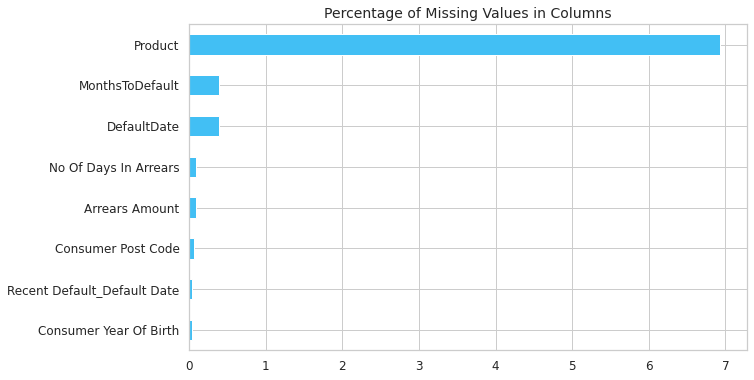

In [129]:
#Visualizing the naturally missing data
missing.plot.barh(figsize = (10, 6), fontsize = 12, color= my_color[0])
plt.title('Percentage of Missing Values in Columns', size = 14)
plt.show()

### Rows


In [0]:
# How much data is missing in each row of the dataset?
missing_r = df.isnull().sum(axis=1)

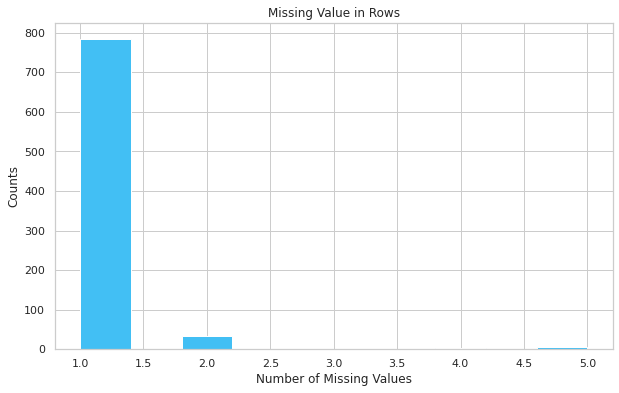

In [131]:
# Visualise
missing_r[missing_r > 0].plot(kind='hist', figsize=(10,6), color=my_color[0])
plt.title('Missing Value in Rows')
plt.ylabel('Counts')
plt.xlabel('Number of Missing Values')
plt.show()

## Convert String to Datetime Type

Columns that should be Datetime type:

* `Application Date`, `Entry Date`, `First Installment Date`, `Expected Contract End Date`, `DefaultDate`, `Recent Default_Default Date`, `Consumer Year Of Birth`

In [0]:
# convert object to datetime

column_date = ['Application Date', 'Entry Date', 'First Installment Date', 'Expected Contract End Date', 'DefaultDate', 'Recent Default_Default Date' ,'Consumer Year Of Birth']

for column in column_date:
  df[column] = pd.to_datetime(df[column])

In [133]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11178 entries, 0 to 11177
Data columns (total 45 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   Contract_Number                             11178 non-null  int64         
 1   Product                                     10403 non-null  object        
 2   Contract_Status                             11178 non-null  object        
 3   Application Date                            11178 non-null  datetime64[ns]
 4   Entry Date                                  11178 non-null  datetime64[ns]
 5   StartHalf                                   11178 non-null  object        
 6   First Installment Date                      11178 non-null  datetime64[ns]
 7   Purchase Amt                                11178 non-null  float64       
 8   Deposit Amt                                 11178 non-null  float64       
 9   Financ

In [134]:
df.head(3)

,Contract_Number,Product,Contract_Status,Application Date,Entry Date,StartHalf,First Installment Date,Purchase Amt,Deposit Amt,Financed Amt,Deposit_Percent,Total Term,Term_Run,Term_Remaining,Payment Type,Total No Of Payments,Freq,Instalment Amt,Total Payments Received,Total Balance Outstanding,Amt Paid To Merchant_nettofmerchfeesandGST,Gtee Rate,Gtee Charges,Est Fees,Proc Fees,Other Fees,Total Merchant Charges,Total Consumer Charges,Total Charges,Effective Billing Rate,Expected Contract End Date,No Of Days In Default,Arrears Amount,No Of Days In Arrears,DefaultAmount,DefaultDate,MonthsToDefault,Recent Default_Default Date,Recent Default_Default Amt,Recent Default_Recov Amt,Consumer Post Code,Consumer Year Of Birth,Merchant Number,Merchant Name,Industry Name
0,61201613,CARAGE,Default,2007-07-14,2007-09-20,2007H2,2007-11-12,14198.0,1698.0,12500.0,0.119594,30,30,0,Bank,30,Mth,416.666667,2916.62,503.38,10344.0,0.1540,1924.99,35.0,0,0.0,1959.99,10.0,1969.99,0.157599,2010-05-12,996,503.38,342.0,503.38,2008-10-17,13.0,2008-06-19,9583.38,9080.00,2579,1965-12-11,30114737,RANBUILD - SOUTHERN TABLELANDS,Sheds & Carports
1,60894924,AIR CON,Default,2007-06-22,2007-11-06,2007H2,2007-11-16,15422.0,3422.0,12000.0,0.221891,30,30,0,Bank,65,FN,184.586987,3693.37,0.03,9911.1,0.1545,1853.99,45.0,0,0.0,1898.99,30.0,1928.99,0.160749,2010-05-16,942,0.03,302.0,0.03,2008-12-10,13.0,2008-08-12,8306.63,8306.60,4510,1950-09-25,30108863,NATURAL FIBRE PTY LTD,Air Conditioning / Heating
2,61030006,SHUTTER,Default,2007-05-07,2007-08-24,2007H2,2007-09-19,6944.0,0.0,6944.0,0.000000,24,24,0,Bank,52,FN,133.517920,133.53,0.01,5890.3,0.1316,913.83,44.0,0,0.0,957.83,10.0,967.83,0.139376,2009-09-19,1236,0.01,541.0,0.01,2008-02-20,6.0,2007-10-23,6810.47,6810.46,4124,1962-02-12,30107417,MODERN ROOF RESTORATION (QLD) PTY LTD,Roofing / Shutters / Gutters


## Categorical Variables

* Only 1 type: `Contract_Status`

* 2 types: 
`Payment Type`, `Freq`
* 4 types:
`StartHalf`

* Many types:
`Product`, `Consumer Post Code`, `Merchant Name`

In [0]:
# Features have the type of Object
feat_cate = ['Product', 'Contract_Status', 'Payment Type', 'Freq', 'StartHalf', 'Consumer Post Code', 'Merchant Name']

In [0]:
# build a df to show levels & types
feat_cate_df = pd.DataFrame(index = feat_cate, columns = ['levels', 'type'])

for feature in feat_cate:
  
  # number of levels
  levels = df[feature].value_counts().shape[0]
  
  # types
  feat_type = df[feature].dtypes
  
  # fill the df
  feat_cate_df.loc[feature] = [levels, feat_type]

In [137]:
feat_cate_df.sort_values('levels')

,levels,type
Contract_Status,1,object
Payment Type,2,object
Freq,2,object
StartHalf,4,object
Consumer Post Code,1386,object
Product,1881,object
Merchant Name,2268,object


In [138]:
df['Freq'].value_counts()

FN     5629
Mth    5549
Name: Freq, dtype: int64

In [139]:
df['StartHalf'].value_counts()

2007H2    2946
2006H2    2927
2006H1    2795
2007H1    2510
Name: StartHalf, dtype: int64

In [140]:
df['Payment Type'].value_counts()

Bank    9272
CC      1906
Name: Payment Type, dtype: int64

In [141]:
df['Proc Fees'].value_counts()

0    11178
Name: Proc Fees, dtype: int64

Dropped the categorical variable column with only 1 type.
 (Later it has been found that 'Proc Fees' only contains 0. Thus, dropped it here as well.)

In [0]:
# Drop useless columns

df.drop(['Contract_Status', 'Proc Fees'], axis = 1, inplace = True)

In [143]:
df.shape

(11178, 43)

## Calculate Age

* The age of customers on the day of application.

In [0]:
# Calculate Age: days / 365

df['age'] = df['Application Date'] - df['Consumer Year Of Birth']
df['age'] = df['age'].apply(lambda x: x.days / 365)

In [0]:
# Convert float to int

#df_age_nan = df[df['Consumer Year Of Birth'].isnull()] # some people's age is Nan
#df_age_not_nan = df[df.age.notnull()]

In [0]:
#df_age_not_nan['age'] = df_age_not_nan['age'].astype(int)   

In [0]:
#df = df_age_nan.append(df_age_not_nan)

## Percentage

Convert amount to percentage

`Gtee Rate` and` Effective Billing Rate` have already been calculated in the original dataset.

In [0]:
# arrears and all kinds of fees
fees = ['Arrears Amount',
        'DefaultAmount',
        'Recent Default_Default Amt',
        'Recent Default_Recov Amt',
        'Amt Paid To Merchant_nettofmerchfeesandGST',
        'Est Fees',
        'Other Fees',
        'Total Merchant Charges',
        'Total Consumer Charges'

        ]

In [0]:
# convert amount to percentage
for fee in fees:
  df[fee] = df[fee] / df['Financed Amt']

In [0]:
# rename columns (amount -> percentage)
df.rename(columns={'Arrears Amount': 'arrear_p',
                   'DefaultAmount': 'default_p',
                    'Recent Default_Default Amt': 'recent_default_default_p',
                    'Recent Default_Recov Amt': 'recent_default_recov_p',
                    'Amt Paid To Merchant_nettofmerchfeesandGST': 'gst_p',
                    'Est Fees': 'est_fee_p',
                    'Other Fees': 'other_fee_p',
                    'Total Merchant Charges': 'total_merchant_charge_p',
                    'Total Consumer Charges': 'total_consumer_charges'                
                   }, 
          inplace=True)

## Rename Columns

In [0]:
df.rename(columns={'Financed Amt': 'financed_amt', 
                   'Deposit_Percent': 'deposit_percent',
                   'Payment Type': 'payment_type',
                   'Instalment Amt': 'instalment_amt',
                   'Gtee Rate': 'gtee_p',
                   'Effective Billing Rate': 'effective_billing_rate',
                   'No Of Days In Default': 'days_default',
                   'No Of Days In Arrears': 'days_arrears',
                   'MonthsToDefault': 'mth_to_default'              
                   }, 
          inplace=True)

## Re-Encode Non-Numeric Binary Variable

Re-encode: 2-level obj

`Freq`

* FN: Fortnightly
* Mth: Monthly

In [0]:
# Re-encode 'Freq': 2-level obj
# FN: Fortnightly
# Mth: Monthly

df['Freq'] = df['Freq'].map({'FN': 0, 'Mth': 1})

`payment_type`

* Bank
* CC 



In [0]:
df['payment_type'] = df['payment_type'].map({'Bank': 0, 'CC': 1})

## Exploring Data

Is there anyone who does not have arrears?

In [154]:
# Is there anyone who does not have arrears?

df_no_arrears = df[df['recent_default_default_p'] == 0]

print(f"{df_no_arrears.shape[0]} people do not have arrears.")

0 people do not have arrears.


How many people have recovered arrears?

In [155]:
# How many people have recovered arrears?

df_recov = df[df['recent_default_recov_p'] > 0]

print(f'{df_recov.shape[0]} people have recovered arrears.')

4042 people have recovered arrears.


In [156]:
df.sample(3)

,Contract_Number,Product,Application Date,Entry Date,StartHalf,First Installment Date,Purchase Amt,Deposit Amt,financed_amt,deposit_percent,Total Term,Term_Run,Term_Remaining,payment_type,Total No Of Payments,Freq,instalment_amt,Total Payments Received,Total Balance Outstanding,gst_p,gtee_p,Gtee Charges,est_fee_p,other_fee_p,total_merchant_charge_p,total_consumer_charges,Total Charges,effective_billing_rate,Expected Contract End Date,days_default,arrear_p,days_arrears,default_p,DefaultDate,mth_to_default,Recent Default_Default Date,recent_default_default_p,recent_default_recov_p,Consumer Post Code,Consumer Year Of Birth,Merchant Number,Merchant Name,Industry Name,age
8936,61265447,WATCH,2007-09-22,2007-09-26,2007H2,2007-10-22,3060.0,306.0,2754.0,0.100000,18,18,0,0,18,1,153.000000,0.00,2754.00,0.851162,0.1233,339.56,0.011983,0.0,0.135280,0.000000,372.56,0.135280,2009-04-22,1236,1.000000,1236.0,1.000000,2008-02-21,5.0,2007-10-24,1.000000,0.000000,4114,1981-07-31,30102478,WALLACE BISHOP - CHERMSIDE,Jewellery,26.161644
3042,60996129,SYSTEM,2006-06-28,2006-07-11,2006H2,2006-07-19,2167.0,542.0,1625.0,0.250115,12,12,0,0,12,1,135.416667,677.05,857.95,0.891138,0.0805,130.81,0.018462,0.0,0.098960,0.006154,170.81,0.105114,2007-07-19,1500,0.527969,1486.0,0.527969,2007-06-01,11.0,2007-02-01,0.583354,0.055385,4305,1977-08-23,30110847,BEST DEAL 4 U COMPUTERS & IT,Computers,28.865753
4816,60842586,SERVICE,2006-02-10,2006-02-16,2006H1,2006-03-10,1333.1,800.0,533.1,0.600105,6,6,0,0,6,1,88.850000,266.55,266.55,0.878634,0.0728,38.80,0.037516,0.0,0.110298,0.000000,58.80,0.110298,2006-09-10,1725,0.500000,1725.0,0.500000,2006-10-20,8.0,2006-06-22,0.500000,0.000000,2560,1982-08-21,30111009,MIDAS CAR CARE - CAMPBELLTOWN,Auto Repair / Service,23.490411


In [0]:
features = ['financed_amt',      #贷款金额
            'deposit_percent',   #首付比例
            'payment_type',      #还款方式
            'Freq',              #还款频率
            'gst_p',             #GST和商家手续费费率 （占贷款金额的比例，以下同）
            'gtee_p',            #银行担保费率
            'est_fee_p',         #开户费率
            'other_fee_p',       #其他费用费率
            'total_merchant_charge_p',   #以上各种费率总和
            'total_consumer_charges',    #客户所付费用费率
            'effective_billing_rate',    #全部费率之和
            'days_default',	     #
            'arrear_p',          #应还金额所占比例
            'days_arrears',	    
            'default_p',         #初始逾期金额所占比例
            'mth_to_default',
            'recent_default_default_p',  #最近一次逾期金额所占比例          
            'recent_default_recov_p',    #最近一次还款金额所占比例
            'age'                #年龄
]

### Heatmap

In [0]:
df_cor = df[features]

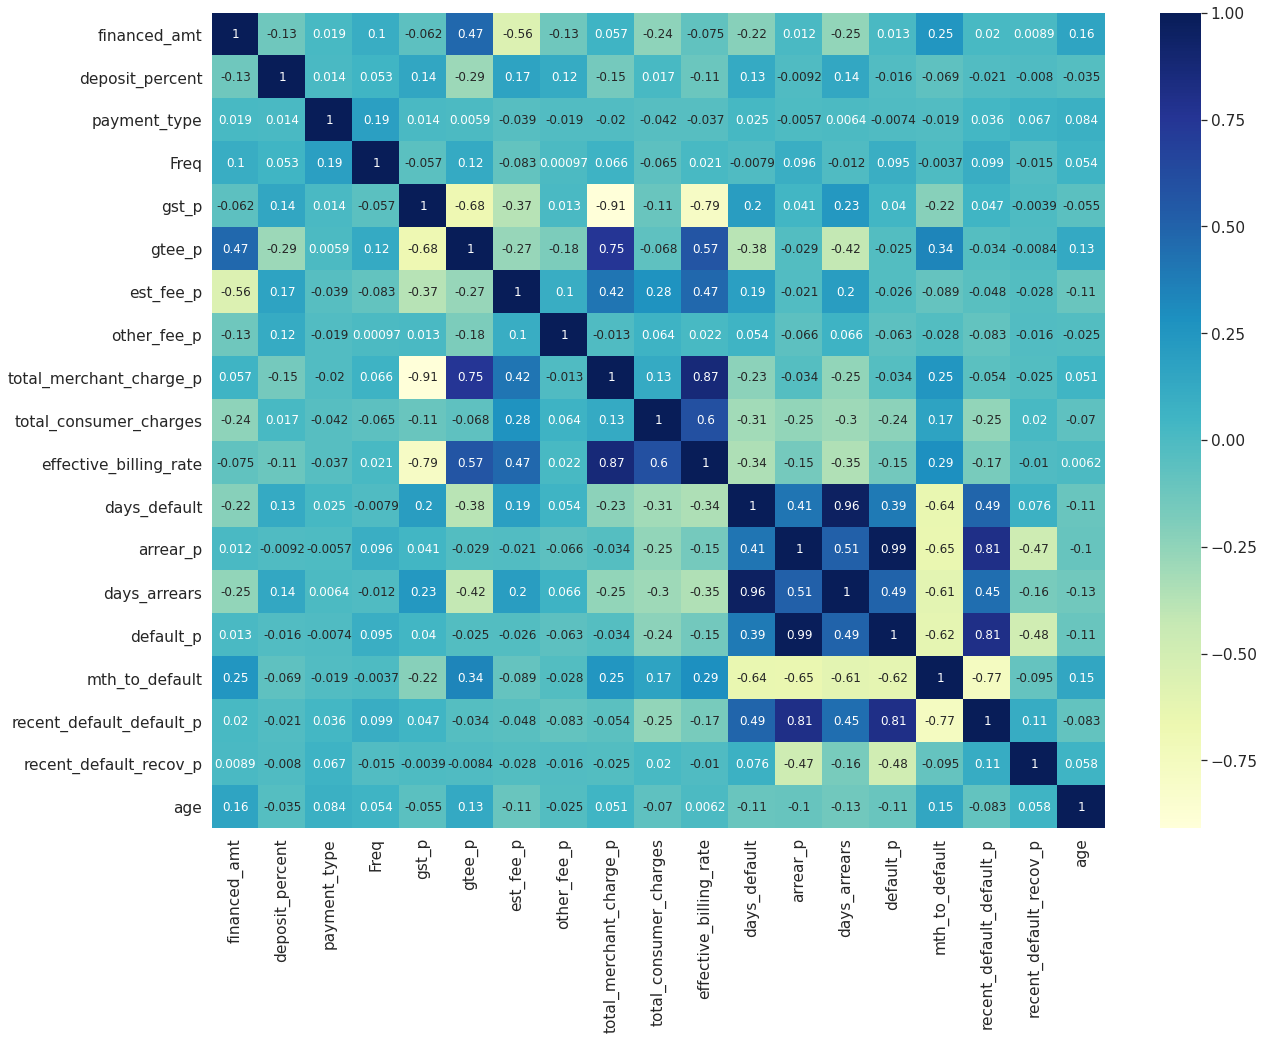

In [159]:
sns.set(font_scale=1.4) #坐标轴字号
fig, ax = plt.subplots(figsize=(20, 15)) 
sns.heatmap(df_cor.corr(), annot=True, cmap="YlGnBu", ax=ax, annot_kws={"size": 12});  #方格中字号

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fada6638c88>,
      dtype=object)

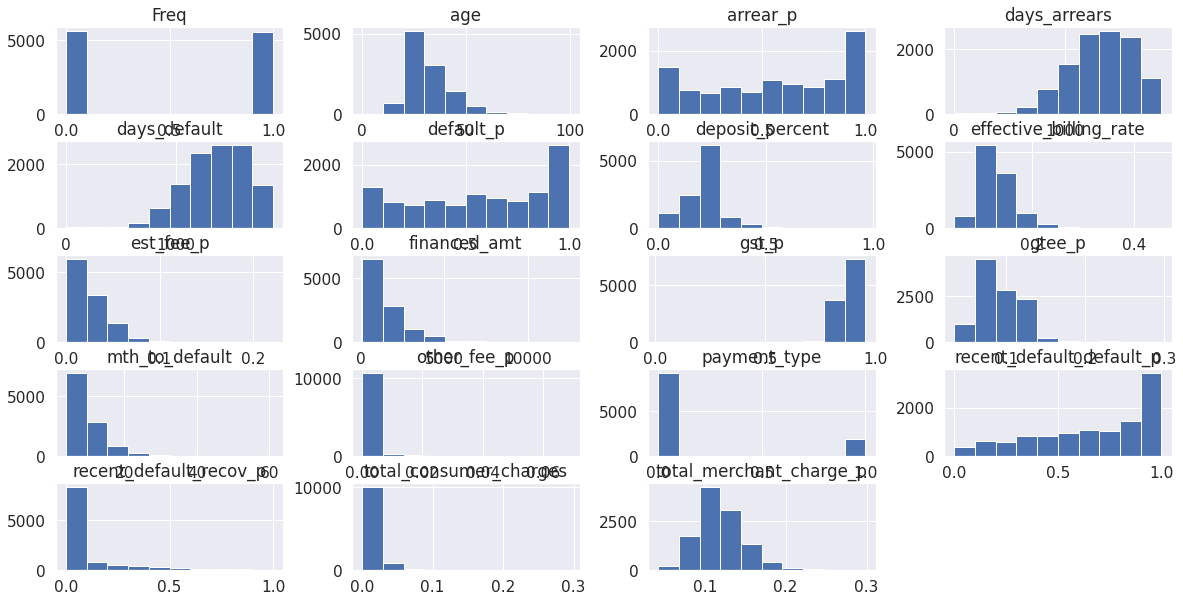

In [160]:
df_cor.hist(figsize=(20,10))

# Step 2： Feature Transformation

### Step 2.1: Apply Feature Scaling 特征缩放

In [0]:
def transform_data(df, cols):
  '''
  impute Nan,
  Transform by StandardScaler: [0, 1]
  '''
  #1 remove all data points with missing values
  df_not_null = df.dropna()

  #2 perform feature scaling on the data WITHOUT missing-value data points
  ##  scaler.fit(data_without_missing_values)
  scaler = StandardScaler()
  model = scaler.fit(df_not_null)

  #3 impute missing values of the original data
  # Impute Nan by mode
  imputer = SimpleImputer(strategy = 'most_frequent')
  data = imputer.fit_transform(df)

  #4 apply the transformation that was previously fit
  #  on the data with all data points and imputed values
  ##  scaler.transform(imputed_data)
  data = model.transform(data)
  
  # Convert data to df
  df = pd.DataFrame(data, columns = cols)
  
  return df, scaler, imputer

In [0]:
df, scaler, imputer = transform_data(df_cor, features)

In [163]:
df.sample(3)

,financed_amt,deposit_percent,payment_type,Freq,gst_p,gtee_p,est_fee_p,other_fee_p,total_merchant_charge_p,total_consumer_charges,effective_billing_rate,days_default,arrear_p,days_arrears,default_p,mth_to_default,recent_default_default_p,recent_default_recov_p,age
7187,3.086152,-1.897891,-0.453564,1.007938,-0.875347,1.753241,-0.972411,-0.216644,0.987656,-0.641950,0.474710,0.339082,1.040327,0.450706,1.042567,-0.648901,0.847842,-0.51041,-0.010711
7081,-0.600164,-0.973739,-0.453564,1.007938,0.122448,-0.597950,0.665136,-0.216644,-0.118452,0.187675,-0.001739,0.374339,-0.450793,0.485352,-0.479776,0.453118,-0.885490,-0.51041,-1.069532
9782,-0.195882,-0.977052,-0.453564,-0.992124,-1.056109,1.514074,-0.345557,-0.216644,1.185779,0.247268,1.077578,-0.792679,-0.450760,-0.661412,-0.479742,0.269448,-0.885451,-0.51041,1.873976


### Step 2.2: Perform Dimensionality Reduction降维

In [0]:
# define PCA function
def do_pca(n_components, data):
    '''
    Transforms data using PCA to create n_components, 
    and provides back the results of the transformation.

    INPUT: n_components - int - the number of principal components to create
           data - the data you would like to transform

    OUTPUT: pca - the pca object created after fitting the data
            X_pca - the transformed X matrix with new number of components
    '''
    #X = StandardScaler().fit_transform(data)
    
    pca = PCA(n_components)
    X_pca = pca.fit_transform(data)
    return pca, X_pca

In [0]:
# Calculate cumulative percentage of variance captured by number of principal components
def calculate_pca_p_of_var(pca):
  '''
  Calculate (cumulative) percentage of variance
  
  Return
  1. p - percentage of variance of a single component
  2. cumulative_p - cumulative percentage of variance
  
  '''
  
  # calculate percentage of variance captured by each principal component
  p = pca.explained_variance_ratio_.tolist()
  
  cumulative_p = []

  for i in range(1, len(p)+1):
    p_sum = np.sum(p[:i])

    cumulative_p.append(p_sum)

  return p, cumulative_p

In [0]:
# plot 1

# Investigate the variance accounted for by each principal component.
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    #for i in range(num_components):
    #    ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

In [0]:
# plot 2

# draw percentage of variance captured by each principal component

def plot_pca_p_of_var(p_list, title):
  '''
  Draw plot of percentage of variance of PCA
  
  p_list - Percentage of Variance in a list
  title - str "Percentage" or "Cumulative Percentage"
  '''
  
  # to df
  var = pd.DataFrame(p_list, columns = [title])
  
  # draw
  fig, ax = plt.subplots(figsize = (16, 8))
  sns.set(style="whitegrid")
  sns.barplot(x = var.index, 
              y = title, 
              data = var, 
              ax = ax).set_title(title)
  
  ax.set(xlabel = 'Principle Component', 
         ylabel = 'Percentage')
         
  
  # x ticks
  ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
  ax.xaxis.set_major_formatter(ticker.ScalarFormatter())

In [0]:
# plot 3

# draw cumulative percentage of variance
def plot_cumulative_p(p_list):
  '''
  p_list - cumulative percentage of variance in a list
  '''
  
  # print
  p = round(p_list[-1], 4) * 100
  print(f"The largest cumulative percentage is {p}% in this case.")
  
  # draw
  plot_pca_p_of_var(p_list, 'Cumulative Percentage of Variance Captured by Each Principle Component')

#### Step 2.2.1 PCA(All components)

In [0]:
# Apply PCA to the data.
pca, X_pca = do_pca(df.shape[1], df)

# get list of percentage 
single_p, cumulative_p = calculate_pca_p_of_var(pca)

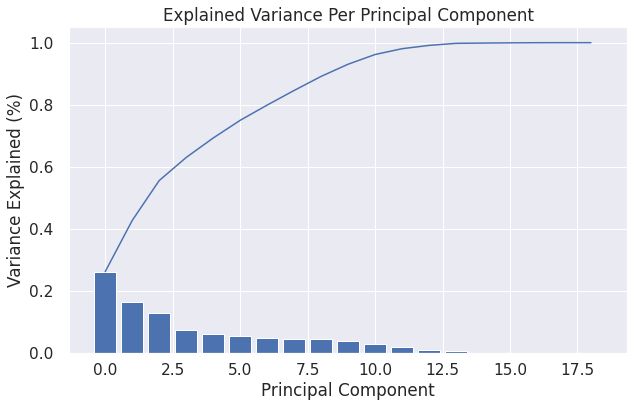

In [170]:
scree_plot(pca)

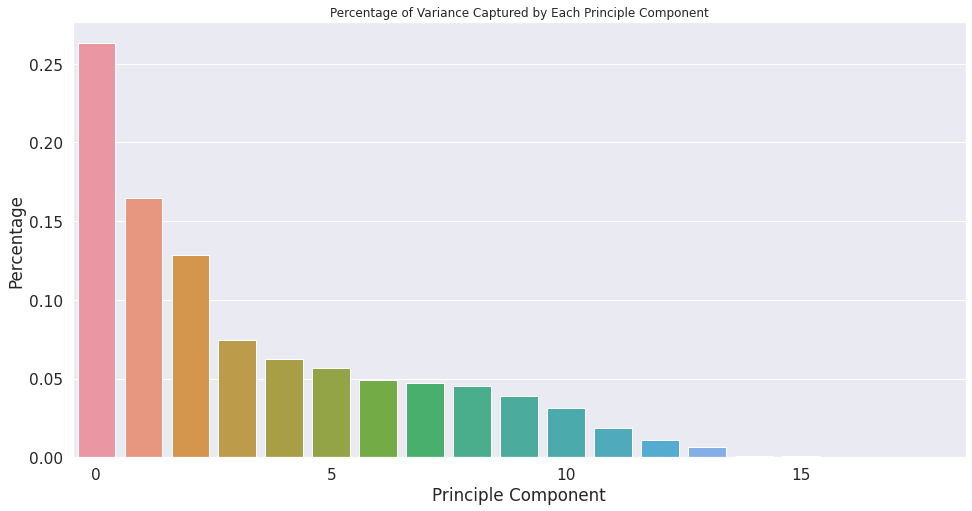

In [171]:
plot_pca_p_of_var(single_p, 'Percentage of Variance Captured by Each Principle Component')

The largest cumulative percentage is 100.0% in this case.


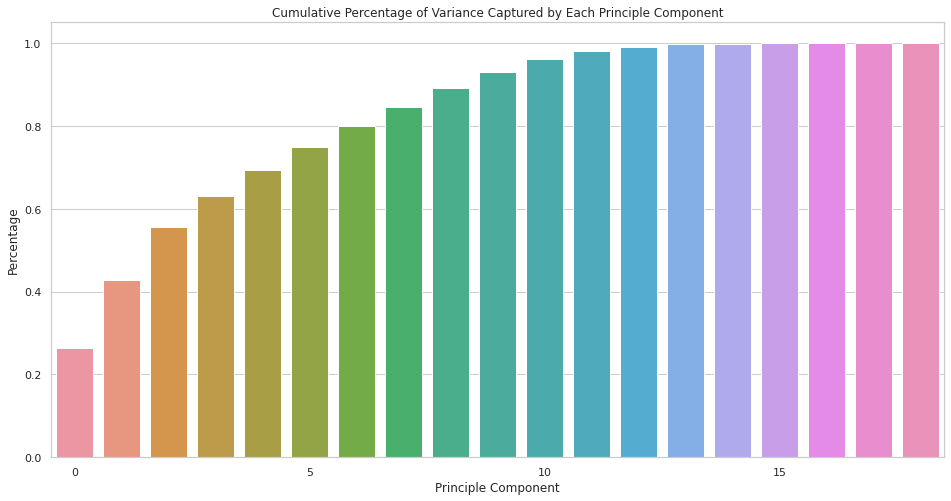

In [172]:
plot_cumulative_p(cumulative_p)

#### Step 2.2.2 PCA (69 components, 95% variance)

In [173]:
# Calculate how many PCAs (95% variance)

for i, p in enumerate(cumulative_p):
  if p >= 0.95:
    print(f'When there is {i+1} components, the cumulative percentage of variance reaches 95%, which is {round(p*100, 2)}.')
    break

When there is 11 components, the cumulative percentage of variance reaches 95%, which is 96.19.


In [0]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca, X_pca = do_pca(11, df)

X_pca = pd.DataFrame(X_pca)

single_p, cumulative_p = calculate_pca_p_of_var(pca)

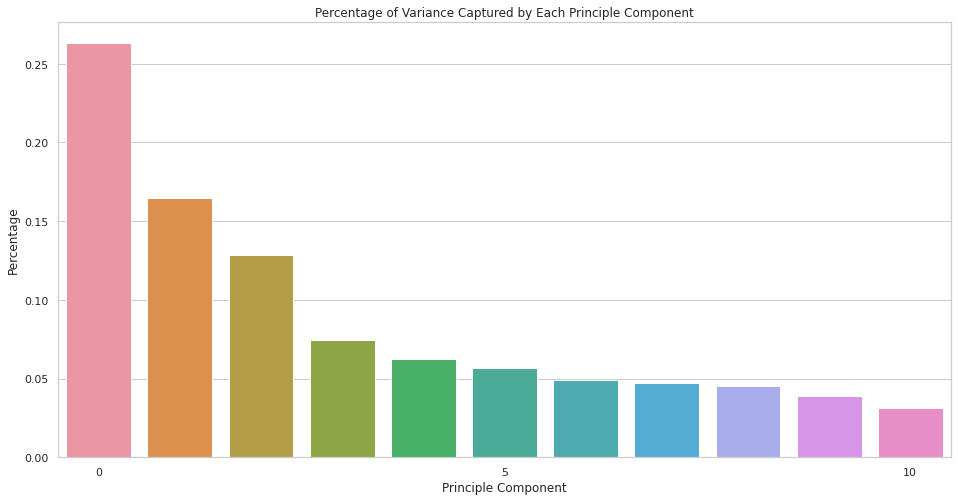

In [177]:
plot_pca_p_of_var(single_p, 'Percentage of Variance Captured by Each Principle Component')

The largest cumulative percentage is 96.19% in this case.


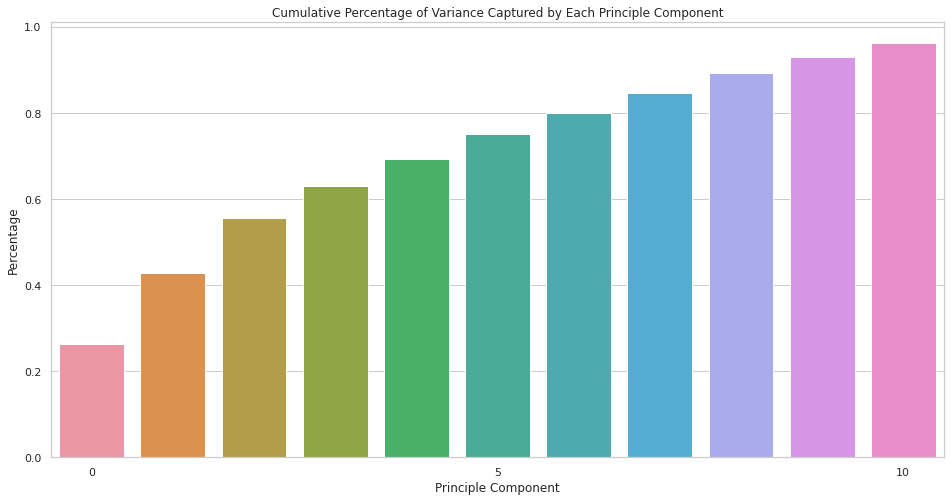

In [178]:
plot_cumulative_p(cumulative_p)

### Step 2.3: Interpret Principal Components 解释主成分


In [0]:
# Map weights for principal components to corresponding feature names

def create_weight_df(pca, cols):
  '''
  To build a dataframe containing weights & variance of pca
  
  cols - column names of df (general population)
  '''

  weights = pca.components_.tolist()
  p_variance = pca.explained_variance_ratio_.tolist()

  df = pd.DataFrame(weights, columns = cols)
  df['p_variance'] = p_variance

  return df

In [0]:
weight_df = create_weight_df(pca, features)

In [190]:
weight_df

,financed_amt,deposit_percent,payment_type,Freq,gst_p,gtee_p,est_fee_p,other_fee_p,total_merchant_charge_p,total_consumer_charges,effective_billing_rate,days_default,arrear_p,days_arrears,default_p,mth_to_default,recent_default_default_p,recent_default_recov_p,age,p_variance
0,0.084773,-0.074130,-0.010180,-0.005441,-0.242905,0.257985,0.025388,-0.010646,0.257642,0.176277,0.295244,-0.349587,-0.315140,-0.366291,-0.309150,0.347809,-0.307114,0.065070,0.073857,0.263102
1,0.009600,-0.096481,-0.009569,0.077712,-0.415752,0.318624,0.193530,-0.046821,0.435888,0.011289,0.356417,0.076836,0.329747,0.092888,0.329669,-0.147993,0.280536,-0.140752,-0.030544,0.164520
2,-0.491965,0.192632,-0.058421,-0.132331,-0.062178,-0.321177,0.524576,0.188202,0.068287,0.310830,0.209956,0.157960,-0.136809,0.161343,-0.141311,-0.074138,-0.122760,0.056436,-0.153421,0.128522
3,0.045752,-0.007000,0.278996,0.153771,-0.150941,0.101744,0.037090,-0.030332,0.121064,-0.231937,-0.018231,0.310920,-0.233579,0.123967,-0.254287,-0.163018,0.163623,0.685128,0.195323,0.074261
4,-0.006968,0.390607,0.513053,0.596306,0.005103,-0.061374,0.059384,0.246087,0.006097,-0.005671,0.002079,-0.052635,0.053021,0.016845,0.057287,0.124339,-0.113998,-0.270121,0.223725,0.062608
5,-0.116524,-0.125893,0.286458,0.206256,0.167999,-0.088013,-0.092401,-0.233132,-0.156371,0.511809,0.129381,-0.267490,0.087340,-0.316444,0.094113,-0.248439,0.289838,0.264699,-0.200024,0.056993
6,0.200750,0.255308,-0.356243,0.155339,-0.018637,0.072633,-0.181473,0.695869,0.014421,0.034526,0.028823,-0.072171,0.005990,-0.129727,0.006856,-0.117076,0.158870,0.223511,-0.327772,0.049060
7,-0.049468,-0.155366,-0.062551,-0.253984,0.049926,-0.078454,-0.022335,0.370015,-0.050746,0.201577,0.059681,-0.093755,0.089329,-0.101119,0.092937,-0.133440,0.132189,0.037658,0.799897,0.047043
8,-0.096335,-0.715407,0.389897,-0.023478,-0.001177,0.005945,-0.062513,0.454996,-0.000841,-0.052771,-0.026992,0.070633,-0.036845,0.098967,-0.030915,0.035802,-0.114039,-0.114701,-0.259464,0.045314
9,0.154106,0.386653,0.538034,-0.680143,-0.050140,0.062139,-0.042956,0.100480,0.041002,-0.054174,0.005982,-0.084892,0.052825,-0.089324,0.053686,-0.025032,0.066281,0.004923,-0.160643,0.039165


In [0]:
def show_weight_pca(df, i, n, features):
  '''
  To print sorted list of feature weights 
  of a principle component.
  
  df - weight dataframe
  
  i - the [i] th principle component
  
  n - number of features

  features - column names without p_variance
  
  '''
  negative = df[features].loc[i-1].sort_values()[:n]
  positive = df[features].loc[i-1].sort_values(ascending = False)[:n]
  
  variance = round(df.loc[i-1]['p_variance'], 4)
  
  print('-' * 32)
  print(f'Principal Component {i}')
  print('-' * 32)
  print(positive)
  print('-' * 32)
  print(negative)
  print('-' * 32)
  print(f'Variance = {variance}')
  print('\n')

In [193]:
# print feature weights of the first 3 principal components

for i in range(1, 4):
  show_weight_pca(weight_df, i, 5, features)

--------------------------------
Principal Component 1
--------------------------------
mth_to_default             0.347809
effective_billing_rate     0.295244
gtee_p                     0.257985
total_merchant_charge_p    0.257642
total_consumer_charges     0.176277
Name: 0, dtype: float64
--------------------------------
days_arrears               -0.366291
days_default               -0.349587
arrear_p                   -0.315140
default_p                  -0.309150
recent_default_default_p   -0.307114
Name: 0, dtype: float64
--------------------------------
Variance = 0.2631


--------------------------------
Principal Component 2
--------------------------------
total_merchant_charge_p    0.435888
effective_billing_rate     0.356417
arrear_p                   0.329747
default_p                  0.329669
gtee_p                     0.318624
Name: 1, dtype: float64
--------------------------------
gst_p                    -0.415752
mth_to_default           -0.147993
recent_default_rec

# Step 3: Clustering

## Step 3.1 KMeans

In [0]:
def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters = center)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    
    return score

In [0]:
# Over a number of different cluster counts,
    # run k-means clustering on the data and
    # compute the average within-cluster distances.

scores = []
centers = list(range(1,30,2))

for center in centers:
  print(center)
  score = get_kmeans_score(X_pca, center) 
  scores.append(score)

In [196]:
# show scores in df

scores_df = pd.DataFrame(data = {'centroid': centers, 'score': scores})
scores_df

,centroid,score
0,1,206336.244850
1,3,152575.160914
2,5,132427.635219
3,7,118149.142906
4,9,107648.142189
5,11,101410.773092
6,13,96154.395136
7,15,92329.406857
8,17,88861.192773
9,19,86074.852158


In [0]:
#scores_df.to_csv('data/kmeans_score.csv', index = False)
scores_df = pd.read_csv('data/kmeans_score.csv')

In [0]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

def plot_kmeans_scores(centers, scores):
  plt.plot(centers, scores, 
           linestyle='--', marker='o', 
           color=my_color[0])
  
  plt.xlabel('K-centroids', fontsize = 12)
  plt.ylabel('Score - Sum of Squared Errors', fontsize = 12)
  plt.title('Relationship between \nSum of Squared Errors v.s. \nNumber of Centroids', size = 14)

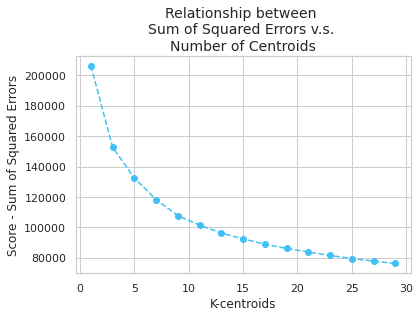

In [200]:
plot_kmeans_scores(scores_df['centroid'], scores_df['score'])

In [0]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

n = 3

#fit_predict - Compute cluster centers and predict cluster index for each sample.
kmeans = KMeans(n_clusters = n)
general_predict = kmeans.fit_predict(X_pca)

In [221]:
# Cluster Validation
# From https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

#The best value is 1 and the worst value is -1. 
#Values near 0 indicate overlapping clusters. 

silhouette_avg = silhouette_score(X_pca, general_predict)
print("For n_clusters =", n,
      "The average silhouette_score is :", silhouette_avg)

For n_clusters = 3 The average silhouette_score is : 0.156842713673617


## Step 3.2 Plot


In [0]:
def build_cluster_df(prediction):
  '''
  To put kmeans prediction result (array) into a dataframe
  '''
  x = np.array(prediction)
  cluster, counts = np.unique(x, return_counts=True)
  
  df = pd.DataFrame({'Cluster': cluster, 'Counts': counts})

  df['Proportion'] = round(df['Counts'] / df['Counts'].sum() * 100, 2)
  
  return df

In [235]:
df_pre = build_cluster_df(general_predict)
df_pre

,Cluster,Counts,Proportion
0,0,3471,31.05
1,1,2308,20.65
2,2,5399,48.30


In [0]:
# Draw a plot
def plot_cluster_comparison(df):
  barWidth = 0.3
  r1 = np.arange(df.shape[0])

  plt.figure(figsize=(8,6))

  plt.bar(r1, df_pre['Proportion'], width = barWidth, color = my_color[0], edgecolor = 'black', capsize=12)

  plt.xticks(ticks = r1)

  # general layout
  plt.xlabel('Cluster No.', fontsize = 12)
  plt.ylabel('Percentage (%)', fontsize = 12)
  plt.title("Proportion of People in Each Cluster", size = 14)
  plt.legend()

No handles with labels found to put in legend.


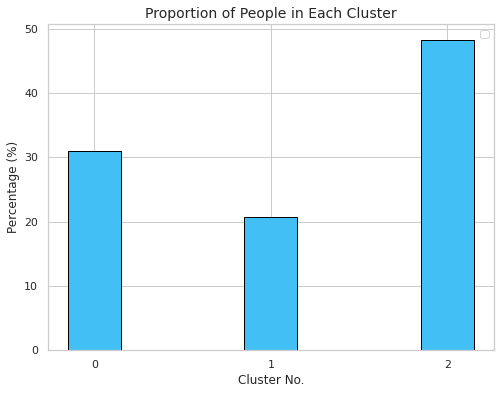

In [234]:
plot_cluster_comparison(df_pre)

## Step 3.3 Inverse Data

What kinds of people are they in each cluster?

In [0]:
def get_top5_feat(df, i, n, cols):
  '''
  To get sorted list of feature weights 
  of a principle component.
  
  df - weight dataframe
  
  i - the [i] th principle component
  
  n - number of features

  cols - column names excluding 'p_variance'
  
  '''
  
  negative = df[cols].loc[i-1].sort_values()[:n]
  positive = df[cols].loc[i-1].sort_values(ascending = False)[:n]
  
  variance = round(df.loc[i-1]['p_variance'], 4)
  
  return negative, positive, variance

In [0]:
def get_cluster_top5_feat(j, weight_df, cols):
  '''
  To get top 5 important positive / negative features 
  of a principle component
  
  INPUT: j - Principle Component No.
         weight_df - a df of pca weight (pca.components_) from step2.3 above
         cols - column names excluding 'p_variance'
  
  OUTPUT: a list of top 5 positive / negative features
  '''
  positive, negative, variance = get_top5_feat(weight_df, j, 5, cols)
  top5_feat = positive.index.tolist() + negative.index.tolist() 
  
  return top5_feat

In [0]:
get_cluster_top5_feat(1, weight_df, features)

In [0]:
def inverse_cluster(i, cols, kmeans):
  '''
  To apply the inverse transform through the PCA transform,
  to get the scaled scores (not back to the original data)
  of all columns
  
  INPUT: i - cluster No.
         cols - all of column names of cleaned data
         kmeans - fitted kmeans object from step3.1
         
  OUTPUT: a df including scalced scores & column names(index)
  '''
  # inverse transform to scalered data
  cluster = kmeans.cluster_centers_[i]
  scaled_score = pca.inverse_transform(cluster)
  
  # to dataframe
  df = pd.DataFrame({'Scaled Score': scaled_score}, index = cols)
  
  return df

In [256]:
inverse_cluster(2, features, kmeans)

,Scaled Score
financed_amt,-0.022513
deposit_percent,0.022329
payment_type,0.008836
Freq,0.086849
gst_p,0.093656
gtee_p,-0.090188
est_fee_p,-0.020776
other_fee_p,-0.078102
total_merchant_charge_p,-0.095600
total_consumer_charges,-0.294961


In [0]:
def get_target_customer(i, j, weight_df, cols, kmeans):
  '''
  To get scaled scores of top 5 posi / nega features
  of a cluster.
  
  USED 2 functions above
  
  OUTPUT: a df - top5 features(index) & scaled scores
  '''
  # get top 5 features of principle component No.j
  features = get_cluster_top5_feat(1, weight_df, cols)
  
  # get scaled scores of cluster No.i
  df = inverse_cluster(i, cols, kmeans)
  
  # get 10-feature df
  df = df.loc[features]
  df.sort_values('Scaled Score', ascending=False, inplace = True)

  return df


In [0]:
def plot_cluster_top5_feat(df, i):
  '''
  To plot the scaled scores of top 5 posi / nega features
  of a cluster.
  
  INPUT: i - cluster No.[i]
         df - a cluster's scaled score df
  '''
  fig, ax = plt.subplots(figsize = (8, 5)) 

  barwidth = 0.5 # the width of the bars 
  r = np.arange(df.shape[0])  # the x locations for the groups  
  y = df['Scaled Score']

  ax.barh(r, y, barwidth, color = my_color[0], capsize=12)

  ax.set_yticks(r + barwidth/2)
  ax.set_yticklabels(df.index, minor=False)
  
  for j, v in enumerate(y):
    if v > 0:
      ax.text(-0.2, j - 0.3, str(round(v,2)), color=my_color[0], size = 12)
    elif v < 0:
      ax.text(0.1, j - 0.3, str(round(v,2)), color=my_color[0], size = 12)

  plt.title(f'Top 5 Positive / Negative Weighted Features of Cluster {i}', size = 14)
  plt.xlabel('Scaled Score', fontsize = 12)
  plt.ylabel('Features', fontsize = 12)      
  plt.show()
  #plt.savefig(os.path.join('test.png'), dpi=300, format='png', bbox_inches='tight')

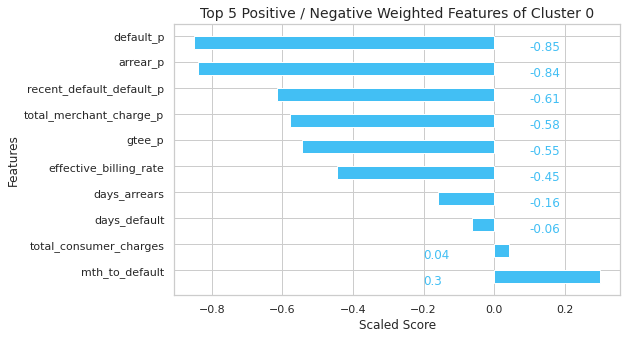

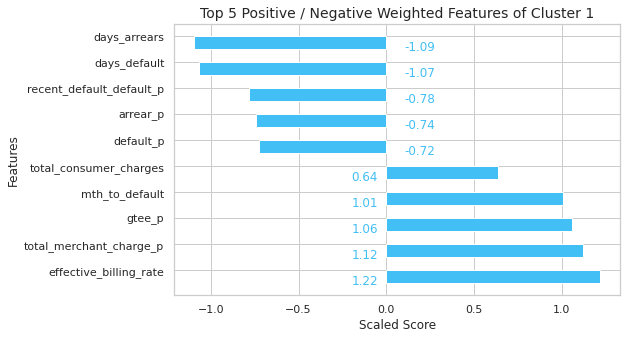

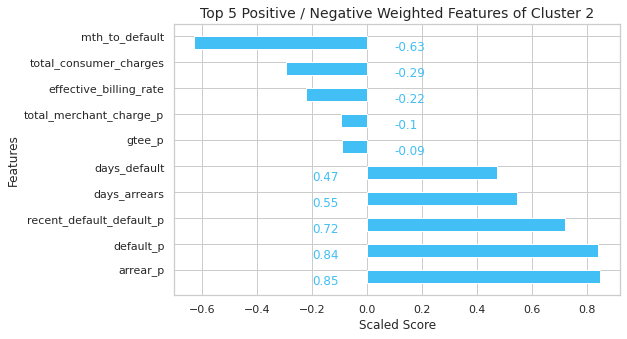

In [258]:
for cluster in range(n):
  df = get_target_customer(cluster, 1, weight_df, features, kmeans)
  #print(df)
  plot_cluster_top5_feat(df, cluster)